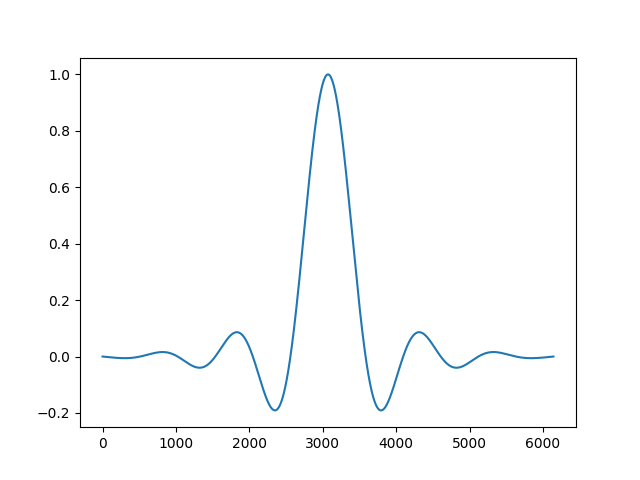

In [51]:
import scipy.signal as spsig
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt

# h = np.concatenate([spsig.firwin(taps_per_channel*number_channels, 1/number_channels, window="hamming")])

# Generate a filter for a "spectrum analyzer" config of 2048 channels with ~4 taps/filter
## Settings for the ATA
fine_channels_per_coarse = 2**18 # used at ATA right now
number_channels = 2048
taps_per_channel = 4

## Settings for GBT
fine_channels_per_coarse = 2**20
number_channels = 512
taps_per_channel = 12

# This is standard window method, but produces a filter that is slightly different than casper
h = spsig.firwin(taps_per_channel*number_channels, 1/number_channels, window="hamming", pass_zero=True)


prototype_length = number_channels * taps_per_channel
# The 0.5 is there to match a bug in casper
t = (0.5+np.arange(prototype_length, dtype=np.float32))/number_channels - taps_per_channel/2
h = np.float32(np.sinc(t) * spsig.get_window("hamming", Nx=prototype_length))

plt.figure()
plt.plot(h)

                                 
# Mimic the rounding to fixed point taps provided in pfbcoeffs.csv
# NB: we know some telescopes (GBT) use truncated rather than rounded numbers in some places (https://github.com/casper-astro/publications/blob/master/Memos/files/DC_FFT.md)
h_rounded = np.round((h/np.max(h)) * 2**17)


In [39]:

# Pad to length of all channels so we can extract that response with fine-channel resolution
padding_length = number_channels*fine_channels_per_coarse - len(h)

h_padded = np.concatenate([h, np.zeros(padding_length, dtype=np.float32)])


In [40]:
# Compute magnitude response of filter
H = np.fft.fftshift(np.fft.fft(h_padded))
H_mag = np.square(np.abs(H))


In [41]:
H_mag.dtype

dtype('float64')

In [42]:
# This is primarily for visualization
H_len = number_channels * fine_channels_per_coarse

# Look at just the passband of a single coarse channel
H_passband = H_mag[H_len//2 - fine_channels_per_coarse//2  - 0*fine_channels_per_coarse : H_len//2 + fine_channels_per_coarse//2 + 0*fine_channels_per_coarse]

# extract passband response centered at our channel + 1 channels on each side (3 total channels worth)
H_passband_aliased = H_mag[H_len//2 - fine_channels_per_coarse//2  - 1*fine_channels_per_coarse : H_len//2 + fine_channels_per_coarse//2 + 1*fine_channels_per_coarse]
H_passband_aliased = H_passband_aliased.reshape((3, fine_channels_per_coarse)).sum(0)

# Look at passband of all channels contributing, this is the one we'll actually use for correction
H_passband_all = H_mag[fine_channels_per_coarse//2 : -fine_channels_per_coarse//2].reshape((-1, fine_channels_per_coarse)).sum(0)

print(H_passband_aliased.shape)
# Give unity gain at peak (should be DC)
H_passband = H_passband / np.max(H_passband)
H_passband_aliased = H_passband_aliased / np.max(H_passband_aliased)
H_passband_all = H_passband_all / np.max(H_passband_all)


(1048576,)


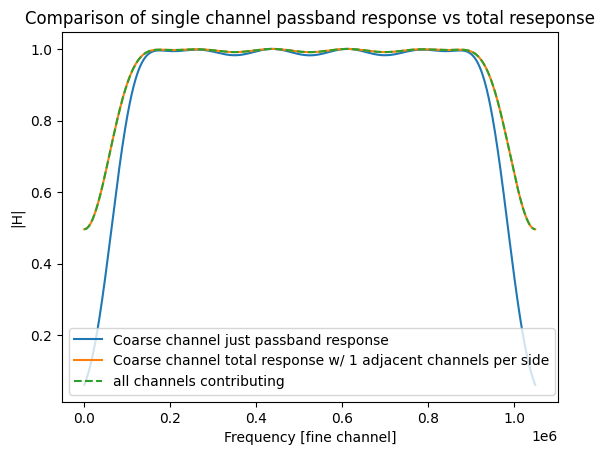

In [43]:
# Plot our filter response
plt.figure()
plt.title("Comparison of single channel passband response vs total reseponse")
plt.plot(np.square(H_passband))
plt.plot((H_passband_aliased))
plt.plot((H_passband_all), '--')
plt.xlabel("Frequency [fine channel]")
plt.ylabel("|H|")
plt.legend(["Coarse channel just passband response", "Coarse channel total response w/ 1 adjacent channels per side", "all channels contributing"])


In [44]:
import h5py
import hdf5plugin

fil = h5py.File("/home/nathan/datasets/voyager_2020_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5")


In [45]:
fil["data"].shape

(16, 1, 1048576)

In [46]:
channel = 0
# extract out a single channel
ata_ch = fil["data"][:, 0, fine_channels_per_coarse*channel:fine_channels_per_coarse*(channel+1)]


In [53]:
# This will make the plots easier to deal with on ATA data
dc_bin = fine_channels_per_coarse//2
ata_ch[:,dc_bin] = (ata_ch[:,dc_bin-1]+ata_ch[:,dc_bin+1])/2

In [54]:
print(ata_ch.shape)
print(H_passband_all.shape)

(16, 1048576)
(1048576,)


Text(0.5, 1.0, 'Corrected Spectra')

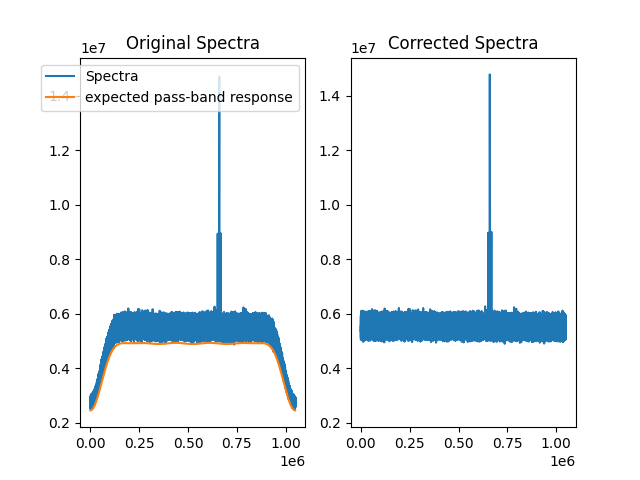

In [57]:
plt.figure()
ax = plt.subplot(121)
plt.plot(np.mean(ata_ch, 0))
plt.plot(H_passband_all*4.93e6) # Factor hard coded to make them line up at noise floor of this coarse channel
plt.legend(["Spectra", "expected pass-band response"])
plt.title("Original Spectra")
plt.subplot(122, sharey=ax, sharex=ax)
plt.plot(np.mean(ata_ch / H_passband_all, 0))
plt.title("Corrected Spectra")

# plt.suptitle("Comparison of original spectra and compensated with filter shape")